
# Neural ODE on a 2D Spiral with Adjoint Interpretation (Adaptive RK)

This notebook accompanies the second example in Section~\ref{sec:NeuralODE}
of the *Mathematics of Generative AI* living book.


In [1]:

import os
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim

os.makedirs("figs", exist_ok=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

torch.manual_seed(1)
np.random.seed(1)


Using device: cpu


In [2]:

alpha_true = 0.3
omega_true = 2.0

T_final = 5.0
N_steps = 200
t_grid = torch.linspace(0.0, T_final, N_steps + 1)

def true_spiral(t, alpha=alpha_true, omega=omega_true):
    r = torch.exp(-alpha * t)
    return torch.stack([r * torch.cos(omega * t),
                        r * torch.sin(omega * t)], dim=-1)

with torch.no_grad():
    x_true = true_spiral(t_grid)

noise_std = 0.03
x_noisy = x_true + noise_std * torch.randn_like(x_true)

x0 = x_noisy[0]


In [3]:

class NeuralDrift(nn.Module):
    def __init__(self, dim=2, hidden_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, dim),
        )

    def forward(self, x):
        return self.net(x)


In [4]:

def rk4_step(f, x, t, h):
    k1 = f(x, t)
    k2 = f(x + 0.5 * h * k1, t + 0.5 * h)
    k3 = f(x + 0.5 * h * k2, t + 0.5 * h)
    k4 = f(x + h * k3, t + h)
    return x + (h / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)


def rk4_adaptive_step(f, x, t, h, tol):
    # One adaptive RK4 step using step-doubling for error estimation.
    with torch.enable_grad():
        x_big = rk4_step(f, x, t, h)
        x_half1 = rk4_step(f, x, t, h * 0.5)
        x_half2 = rk4_step(f, x_half1, t + 0.5 * h, h * 0.5)
        err = torch.norm(x_half2 - x_big).detach()

    safety = 0.9
    if err.item() == 0.0:
        factor = 2.0
    else:
        factor = safety * (tol / err.item())**0.25
    factor = max(0.1, min(5.0, factor))
    h_new = h * factor

    accept = err.item() < tol
    x_new = x_half2 if accept else x
    return x_new, h_new, accept


def odeint_adaptive_to_grid(f, x0, t_grid, tol=1e-4, h_init=0.05):
    # Integrate dx/dt = f(x,t) and return x at each t in t_grid.
    x = x0
    traj = [x0]
    t_current = t_grid[0].item()
    h = h_init

    for k in range(len(t_grid) - 1):
        t_target = t_grid[k + 1].item()
        while t_current < t_target:
            if t_current + h > t_target:
                h = t_target - t_current
            x_new, h_new, accept = rk4_adaptive_step(f, x, t_current, h, tol)
            if accept:
                x = x_new
                t_current += h
            h = h_new
        traj.append(x)
    return torch.stack(traj, dim=0)


Iter    1/300: loss = 0.756678
Iter   50/300: loss = 0.078753
Iter  100/300: loss = 0.002943
Iter  150/300: loss = 0.001618
Iter  200/300: loss = 0.001282
Iter  250/300: loss = 0.001176
Iter  300/300: loss = 0.001125


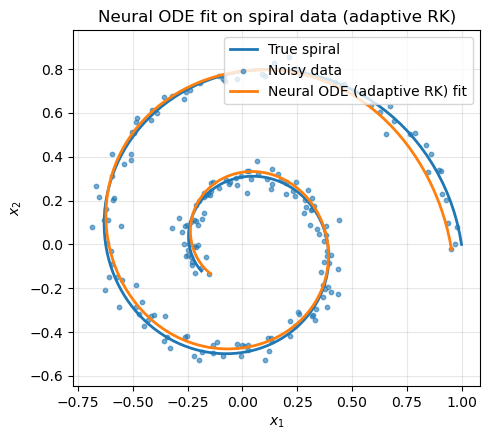

In [5]:

drift = NeuralDrift(dim=2, hidden_dim=64).to(device)

t_grid_dev = t_grid.to(device)
x0_dev = x0.to(device)
x_noisy_dev = x_noisy.to(device)

optimizer = optim.Adam(drift.parameters(), lr=5e-3)
n_iters = 300

loss_history = []

for it in range(1, n_iters + 1):
    optimizer.zero_grad()

    def f(x, t):
        return drift(x)

    x_pred = odeint_adaptive_to_grid(f, x0_dev, t_grid_dev, tol=1e-4, h_init=0.05)
    loss = torch.mean((x_pred - x_noisy_dev.to(device))**2)

    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    if it % 50 == 0 or it == 1:
        print(f"Iter {it:4d}/{n_iters}: loss = {loss.item():.6f}")

drift.eval()
with torch.no_grad():
    def f_trained(x, t):
        return drift(x)
    x_fit = odeint_adaptive_to_grid(f_trained, x0_dev, t_grid_dev,
                                    tol=1e-4, h_init=0.05).cpu()

plt.figure(figsize=(5, 4.5))
plt.plot(x_true[:, 0], x_true[:, 1], label="True spiral", linewidth=2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=10, alpha=0.6, label="Noisy data")
plt.plot(x_fit[:, 0], x_fit[:, 1], label="Neural ODE (adaptive RK) fit", linewidth=2)
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Neural ODE fit on spiral data (adaptive RK)")
plt.legend()
plt.axis("equal")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/neuralode_adjoint_spiral_fit.png", dpi=300, bbox_inches="tight")
plt.show()


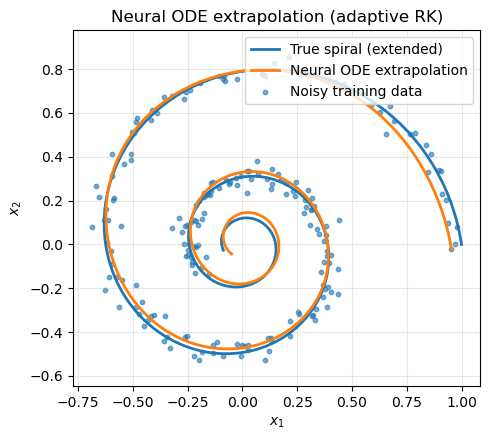

In [6]:

# Extrapolation
T_ext = 8.0
N_ext = 320
t_grid_ext = torch.linspace(0.0, T_ext, N_ext + 1).to(device)

with torch.no_grad():
    x_fit_ext = odeint_adaptive_to_grid(f_trained, x0_dev, t_grid_ext,
                                        tol=1e-4, h_init=0.05).cpu()
    x_true_ext = true_spiral(torch.linspace(0.0, T_ext, N_ext + 1))

plt.figure(figsize=(5, 4.5))
plt.plot(x_true_ext[:, 0], x_true_ext[:, 1], label="True spiral (extended)", linewidth=2)
plt.plot(x_fit_ext[:, 0], x_fit_ext[:, 1], label="Neural ODE extrapolation", linewidth=2)
plt.scatter(x_noisy[:, 0], x_noisy[:, 1], s=10, alpha=0.6, label="Noisy training data")
plt.xlabel(r"$x_1$")
plt.ylabel(r"$x_2$")
plt.title("Neural ODE extrapolation (adaptive RK)")
plt.legend()
plt.axis("equal")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.savefig("figs/neuralode_adjoint_spiral_extrapolation.png", dpi=300, bbox_inches="tight")
plt.show()


grad_xT (terminal gradient): tensor([ 0.0413, -0.0119])
grad_x0 (autograd wrt x0): tensor([-0.0139,  0.0079])
lambda(0) (adjoint):       tensor([-0.0140,  0.0077])
Difference: tensor([3.0573e-05, 2.3911e-04])


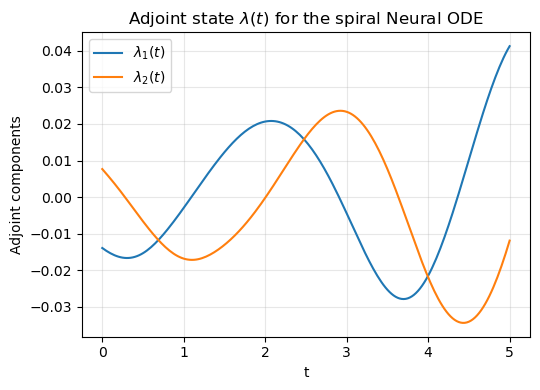

In [8]:
# Adjoint demonstration: terminal loss L = 0.5 ||x(T) - x_true(T)||^2
drift.eval()
def f_trained(x, t):
    return drift(x)

# Initial condition with grad tracking
x0_grad = x0_dev.detach().clone().requires_grad_(True)

# Forward solve with adaptive RK to the grid
x_traj = odeint_adaptive_to_grid(f_trained, x0_grad, t_grid_dev,
                                 tol=1e-4, h_init=0.05)

# Terminal loss
xT = x_traj[-1]
x_true_T = x_true[-1].to(device)
L_terminal = 0.5 * torch.sum((xT - x_true_T)**2)

# Gradient at terminal time
grad_xT = torch.autograd.grad(L_terminal, xT, retain_graph=True)[0]
print("grad_xT (terminal gradient):", grad_xT.cpu())

# ---------------------------------------------------------------------
# Adjoint ODE: dλ/dt = - (∂f/∂x)^T λ, integrated backward in time
# ---------------------------------------------------------------------

def jacobian_x(f, x, t):
    # Compute J = ∂f/∂x at (x,t) via autograd.
    x = x.clone().detach().requires_grad_(True)
    y = f(x, t)
    rows = []
    for i in range(y.shape[-1]):
        grad_i = torch.autograd.grad(y[i], x, retain_graph=True)[0]
        rows.append(grad_i)
    J = torch.stack(rows, dim=0)  # shape (dim, dim)
    return J

def adjoint_rhs(lambda_vec, x, t):
    J = jacobian_x(f_trained, x, t)
    return - J.t().matmul(lambda_vec)

def rk4_step_adjoint(lambda_vec, x, t, h):
    k1 = adjoint_rhs(lambda_vec, x, t)
    k2 = adjoint_rhs(lambda_vec + 0.5 * h * k1, x, t + 0.5 * h)
    k3 = adjoint_rhs(lambda_vec + 0.5 * h * k2, x, t + 0.5 * h)
    k4 = adjoint_rhs(lambda_vec + h * k3, x, t + h)
    return lambda_vec + (h / 6.0) * (k1 + 2.0 * k2 + 2.0 * k3 + k4)

# Backward integration on the uniform grid
lambda_T = grad_xT.detach().cpu()
lambda_current = lambda_T.clone()
lambda_traj = [lambda_current]
h = (t_grid[-1] - t_grid[-2]).item()

for k in range(len(t_grid) - 1, 0, -1):
    t_k = t_grid[k].item()
    x_k = x_traj[k].detach().cpu()
    lambda_current = rk4_step_adjoint(lambda_current, x_k, t_k, -h)
    lambda_traj.append(lambda_current)

lambda_traj = torch.stack(lambda_traj[::-1], dim=0)

# ---------------------------------------------------------------------
# Compare λ(0) to gradient wrt initial condition x(0)
# ---------------------------------------------------------------------

grad_x0 = torch.autograd.grad(L_terminal, x0_grad)[0].detach().cpu()
lambda_0 = lambda_traj[0].detach().cpu()

print("grad_x0 (autograd wrt x0):", grad_x0)
print("lambda(0) (adjoint):      ", lambda_0)
print("Difference:", grad_x0 - lambda_0)

plt.figure(figsize=(5.5, 4))
plt.plot(t_grid, lambda_traj[:, 0], label=r"$\lambda_1(t)$")
plt.plot(t_grid, lambda_traj[:, 1], label=r"$\lambda_2(t)$")
plt.xlabel("t")
plt.ylabel(r"Adjoint components")
plt.title("Adjoint state $\lambda(t)$ for the spiral Neural ODE")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig("figs/neuralode_adjoint_lambda_time.png", dpi=300, bbox_inches="tight")
plt.show()
